In [2]:
!pip install git+https://github.com/citysu/csiread.git



  Cloning https://github.com/citysu/csiread.git to /tmp/pip-req-build-pzvg1vfv
  Running command git clone --filter=blob:none --quiet https://github.com/citysu/csiread.git /tmp/pip-req-build-pzvg1vfv
  Resolved https://github.com/citysu/csiread.git to commit 943ec8466827eff34f8386c963ae8c3e8017ec91
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for csiread: filename=csiread-1.4.1-cp312-cp312-linux_x86_64.whl size=317137 sha256=d5592b2eb257db1c78dedc9e298f32244f0109dbc2698fe78e5ed32895588a30
  Stored in directory: /tmp/pip-ephem-wheel-cache-zgpdcqzs/wheels/7b/11/91/caa2e9f92d1f6fedc3a94e7e3e5980383cc569a97142492a83
Successfully built csiread


# 讀檔

In [3]:
import csiread

# 直接讀取，副檔名不是問題
csi_data = csiread.Intel("ray")
csi_data.read()

print(csi_data.csi.shape)   # (packets, Nrx, Ntx, subcarriers)
#print(csi_data.csi[0])

print("Total packets:", len(csi_data.csi))

(17476, 30, 3, 2)
Total packets: 17476


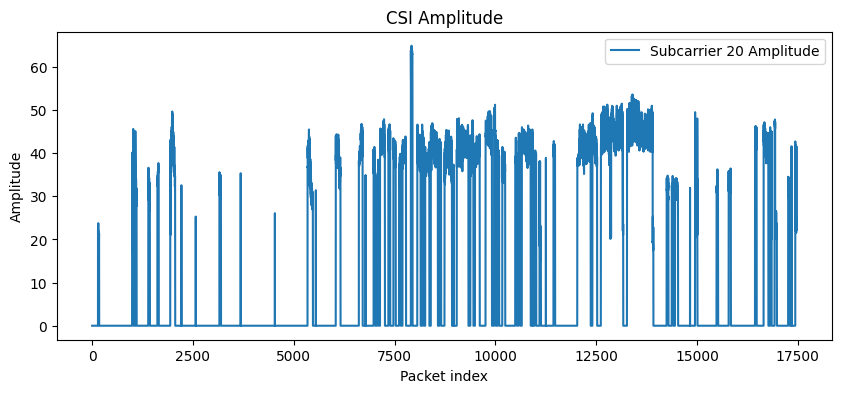

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# CSI 複數矩陣
csi = csi_data.csi   # shape = (packets, Nrx, Ntx, subcarriers)

# 取第1根Rx天線、第1個Tx、第20個子載波
amp = np.abs(csi[:, 20, 0, 0])

# 畫圖
plt.figure(figsize=(10,4))
plt.plot(amp, label="Subcarrier 20 Amplitude")
plt.xlabel("Packet index")
plt.ylabel("Amplitude")
plt.title("CSI Amplitude")
plt.legend()
plt.show()

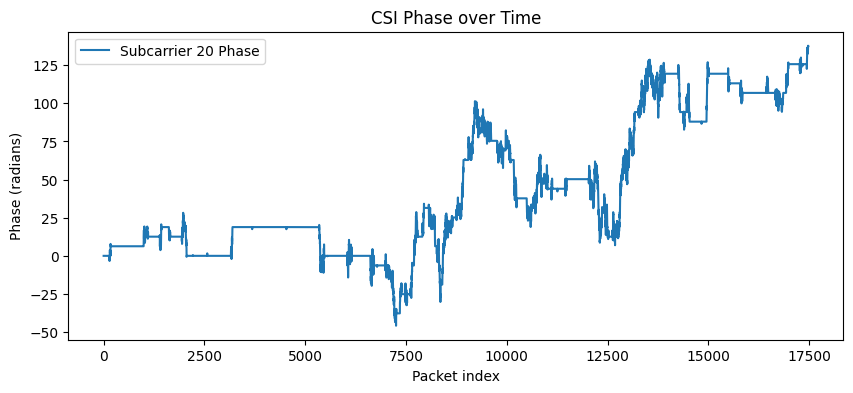

In [5]:
# 相位（需要 unwrap 避免跳躍）
phase = np.angle(csi[:, 0, 0, 0])
phase = np.unwrap(phase)

plt.figure(figsize=(10,4))
plt.plot(phase, label="Subcarrier 20 Phase")
plt.xlabel("Packet index")
plt.ylabel("Phase (radians)")
plt.title("CSI Phase over Time")
plt.legend()
plt.show()

In [ ]:
"""
k = np.arange(len(phase))
coef = np.polyfit(k, phase, 1)   # 線性擬合
trend = np.polyval(coef, k)
corrected = phase - trend

plt.figure(figsize=(10,4))
plt.plot(corrected, label="Subcarrier 20 Phase")
plt.xlabel("Packet index")
plt.ylabel("Phase (radians)")
plt.title("CSI Phase over Time")
plt.legend()
plt.show()

In [ ]:
"""
from scipy.signal import butter, filtfilt

def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

b, a = butter_lowpass(cutoff=0.5, fs=100, order=4)  # 假設封包頻率 ~100Hz
filtered = filtfilt(b, a, corrected)


plt.figure(figsize=(10,4))
plt.plot(filtered, label="Subcarrier 20 Phase")
plt.xlabel("Packet index")
plt.ylabel("Phase (radians)")
plt.title("CSI Phase over Time")
plt.legend()
plt.show()

In [ ]:
"""
amp_all = np.abs(csi[:, 0, 0, :])   # (packets, subcarriers)

plt.figure(figsize=(10,6))
plt.imshow(amp_all.T, aspect="auto", cmap="jet", origin="lower")
plt.colorbar(label="Amplitude")
plt.xlabel("Packet index")
plt.ylabel("Subcarrier index")
plt.title("CSI Amplitude Heatmap")
plt.show()
"""

# 濾波

這格結果不行

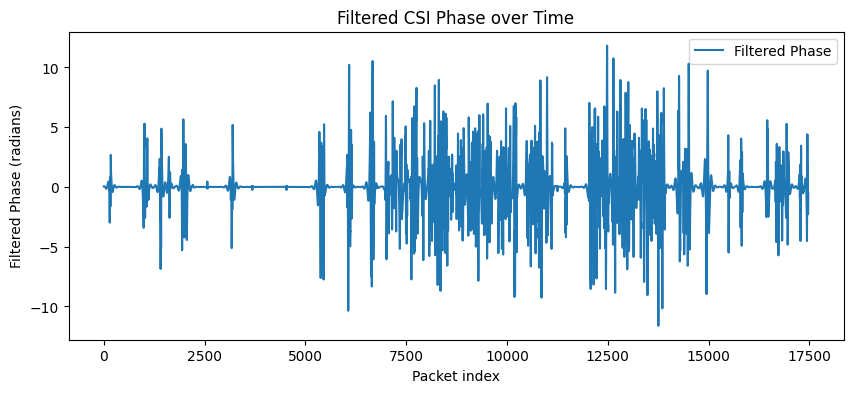

In [9]:
# 偵測呼吸用相位，偵測移動兩者皆可
# 這裡用的是相位
from scipy.signal import butter, filtfilt

# 帶通濾波器允許在特定頻率範圍內傳遞信號，同時阻止該範圍之外的信號
def bandpass_filter(data, low, high, fs, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    return filtfilt(b, a, data)

# 採樣頻率 fs=100Hz，呼吸範圍0.1–0.5Hz
# 這裡因為是動作所以頻率範圍取1-10Hz+
signal_filtered = bandpass_filter(phase, 1, 10, fs=100)


plt.figure(figsize=(10,4))
plt.plot(signal_filtered, label="Filtered Phase")
plt.xlabel("Packet index")
plt.ylabel("Filtered Phase (radians)")
plt.title("Filtered CSI Phase over Time")
plt.legend()
plt.show()

這格還在試

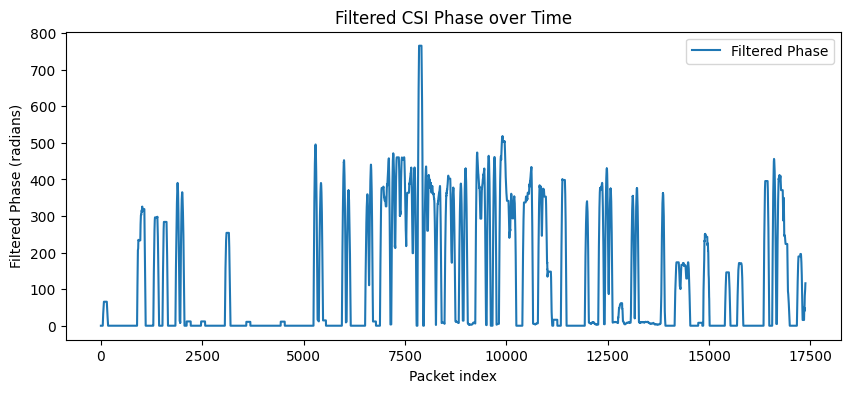

In [7]:
import numpy as np

amp = np.abs(csi[:,0,0,0])
win_size = 100
var_series = [np.var(amp[i:i+win_size]) for i in range(len(amp)-win_size)]

plt.figure(figsize=(10,4))
plt.plot(var_series, label="Filtered Phase")
plt.xlabel("Packet index")
plt.ylabel("Filtered Phase (radians)")
plt.title("Filtered CSI Phase over Time")
plt.legend()
plt.show()

# 特徵提取

In [ ]:
"""
from scipy.fftpack import fft, fftfreq

N = len(signal_filtered)
freq = fftfreq(N, d=1/100)
spectrum = np.abs(fft(signal_filtered))

# 找 0.1~0.5Hz 區間的最大峰值
mask = (freq > 0.1) & (freq < 0.5)
resp_freq = freq[mask][np.argmax(spectrum[mask])]
resp_rate = resp_freq * 60
print("呼吸率:", resp_rate, "次/分鐘")
"""

呼吸率: 0.4978255893797208 次/分鐘
